# 1st order training (optimization) methods

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax

Let us consider the following function

$$
f(x) = e^{-\frac{x}{10}}\sin(x) + \frac{1}{10} \cos(\pi x)
$$

defined over the interval $[0, 10]$.

In [3]:
f = lambda x: np.sin(x) * np.exp(-0.1*x) + 0.1* np.cos(np.pi * x)
a, b = 0, 10

Define a function `get_training_data` that returns a collection of `N` training samples (using an equispaced sampling of the interval $[0,10]$), adding a noise sampled from a normal distribution with zero mean and standard deviation `noise`. The output should be a pair of `numpy` matrices `x, y`, of dimension `N` times 1.

In [4]:
def get_training_data(N, noise):
  np.random.seed(0) # for reproducibility
  x = np.linspace(a, b, N)
  y = f(x) + np.random.normal(0, noise, (N, ))
  return x.reshape((N, 1)), y.reshape(N, 1)

get_training_data(12, 2)

(array([[ 0.        ],
        [ 0.90909091],
        [ 1.81818182],
        [ 2.72727273],
        [ 3.63636364],
        [ 4.54545455],
        [ 5.45454545],
        [ 6.36363636],
        [ 7.27272727],
        [ 8.18181818],
        [ 9.09090909],
        [10.        ]]),
 array([[ 3.62810469],
        [ 1.42475179],
        [ 2.84997142],
        [ 4.72277511],
        [ 3.44658221],
        [-2.59470005],
        [ 1.45878877],
        [-0.21864306],
        [ 0.13194346],
        [ 1.32305597],
        [ 0.32416529],
        [ 2.80841283]]))

Plot now the function $f(x)$ in the considered interval, together with 100 training samples with noise magnitude equal to 0.05.

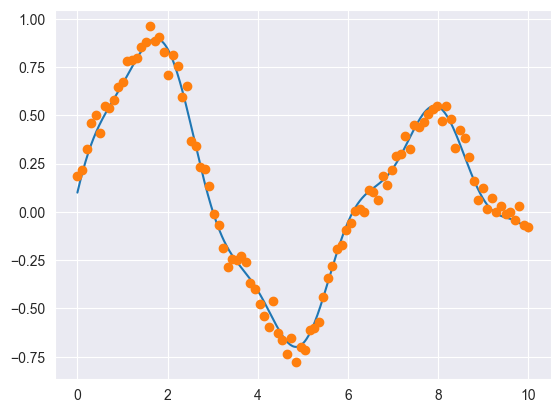

In [5]:
x_fine, y_fine = get_training_data(1000, 0)
plt.plot(x_fine, y_fine)

xx, yy = get_training_data(100, 0.05)
plt.plot(xx, yy, 'o')

Write a function `initialize_params` that, given the input `layers_size = [n1, n2, ..., nL]`, generates the parameters associated with an ANN, having as many layers as the number of elements of `layers_size`, with as many neurons as `n1`, `n2`, etc.

Inizialize weights sampling from a standard Gaussian distribution and biases with zero values.

In [6]:
def initialize_params(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    n, m = layers_size[i + 1], layers_size[i]
    params.append(np.random.normal(0, 1, (n, m)))
    params.append(np.zeros((n, 1)))
  return params

Write a function `ANN` that implements an ANN, given the parameters `params`. Use $\tanh$ as activation function and do not apply the activation function to the last layer.

By convention, both the input and the output have:
- 1 sample per row
- 1 feature per column

**Hint:** to help the training problem, normalize the input in $[-1,1]$.

In [7]:
def ANN(x, params):
    temp = 2 * (x.T - a) / (b - a) - 1
    for i in range(0, len(params), 2):
      if i == len(params) - 2:
        temp = params[i] @ temp + params[i + 1]
      else:
        temp = jnp.tanh(params[i] @ temp + params[i + 1])
    return temp.T

Implement a function `loss`, that given the input `x`, the target output `y` (i.e. the "labels") and the parameters `params`, returns the quadratic loss, defined as:

$$
\mathcal{L}(\mathbf{x}, \mathbf{y}, \boldsymbol{\theta}) = \frac{1}{m} \sum_{i=1}^m (y_i - \mathrm{ANN}(x_i, \boldsymbol{\theta}))^2
$$

where $m$ is the number of samples in `x`, `y` and $\boldsymbol{\theta}$ are the ANN parameters.

In [8]:
def loss(x, y, params):
  error =  ANN(x, params)[:, 0] - y[:, 0]
  return jnp.mean(error * error)

Test your code, by generating the parameters associated with an ANN with two hidden layers with 5 neurons each and by computing the associated loss.

In [9]:
params = initialize_params([1, 5, 5, 1])
loss(xx, yy, params)

Array(0.28158012, dtype=float32)

The following cell provides an helper class that allows online plots during the training loop. Just run the cell, we will use it later.

In [10]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1,2, figsize=(16,8))
    self.x_fine = np.linspace(a, b, 200)[:,None]
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs[0].clear()
      self.axs[0].loglog(history) # double log plot
      self.axs[0].set_title('epoch %d' % (self.epoch + 1))

    self.axs[1].clear()
    self.axs[1].plot(self.x_fine, f(self.x_fine))
    self.axs[1].plot(self.x_fine, ANN(self.x_fine, params))
    self.axs[1].plot(xx, yy, 'o')

## Gradient Descent

Implement the GD method:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}}\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{N} \sum_{i=1}^N \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \lambda \mathbf{g}^{(k)}
\end{split}
$$
where N is the number of training samples. At each iteration, append the current cost to the list `history`.

Hints: 
- Use `jax.jit` to speedup the evaluation of the loss and of the gradients.
- To use the visualization callback, just initialize it outside the training loop with:
```python
cb = Callback(refresh_rate = 250)
```
and after each training epoch call `cb(epoch)`, where `epoch` is the epoch index. Finally, call `cb.draw()` when training is over.

Test you code with:
- 100 training points
- noise magnitude 0.05
- two hidden layers of 5 neurons each
- 2000 epochs

Experiment different choices of learning rate $\lambda$, trying to maximize the performance of the algorithm.

Does it look like your ANN is struggling to learn? Try to figure out why and figure out how to fix this issue.

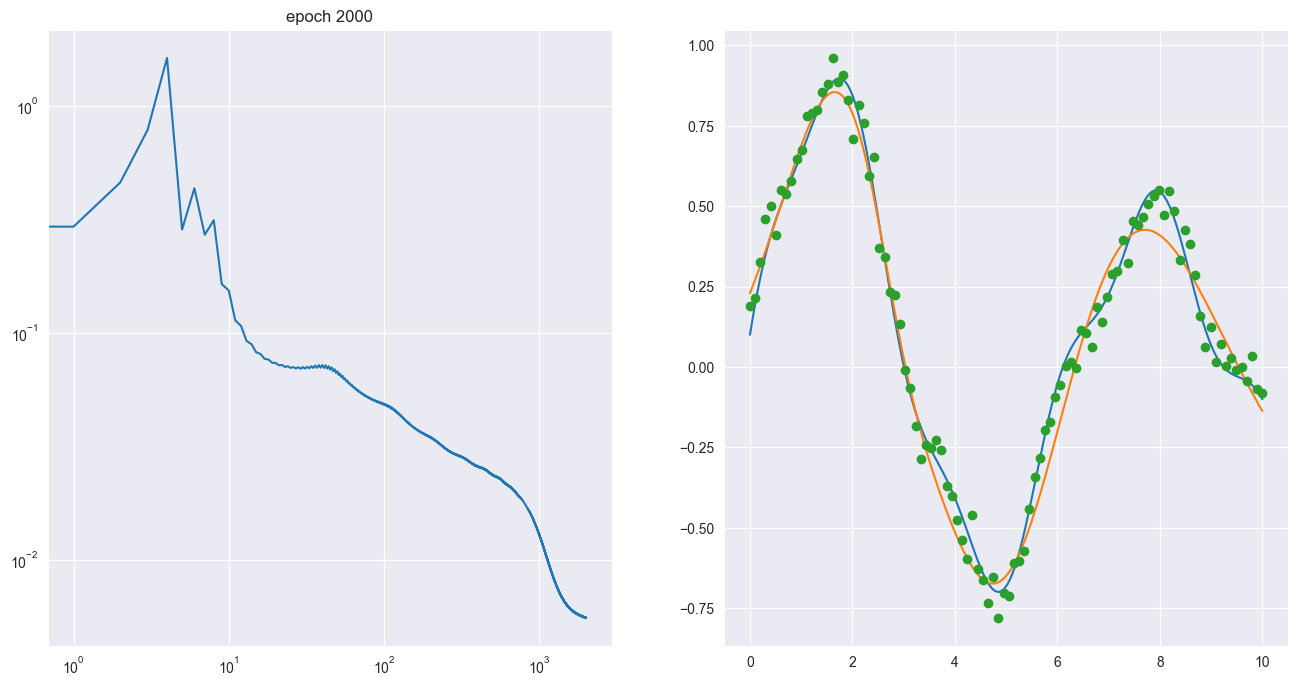

loss: 5.552e-03


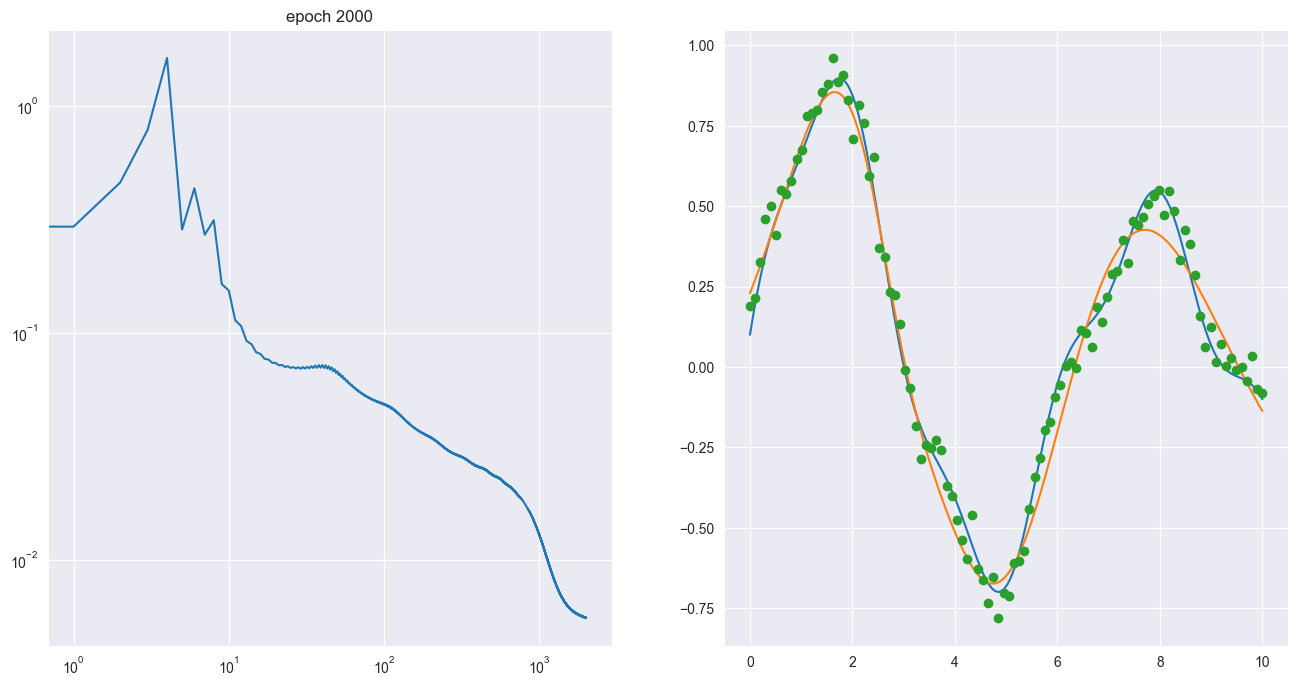

In [11]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 0.1
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 200)

for epoch in range(num_epochs):
  grads = grad_jit(xx, yy, params)
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]
  history.append(loss_jit(xx, yy, params))
  cb(epoch)
#cb.draw()

print('loss: %1.3e' % history[-1])

## Stochastic Gradient Descent

Implement the SGD method:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}}\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \lambda_k \mathbf{g}^{(k)}
\end{split}
$$
where $I_k$ is the current minibatch. To select it, use the function [np.random.choice](https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html) with replacement.

Consider a linear decay of the learning rate:
$$
\lambda_k = \max\left(\lambda_{\textnormal{min}}, \lambda_{\textnormal{max}} \left(1 - \frac{k}{K}\right)\right)
$$

Test different choices of batch size and try to optimize the learning rate decay strategy.

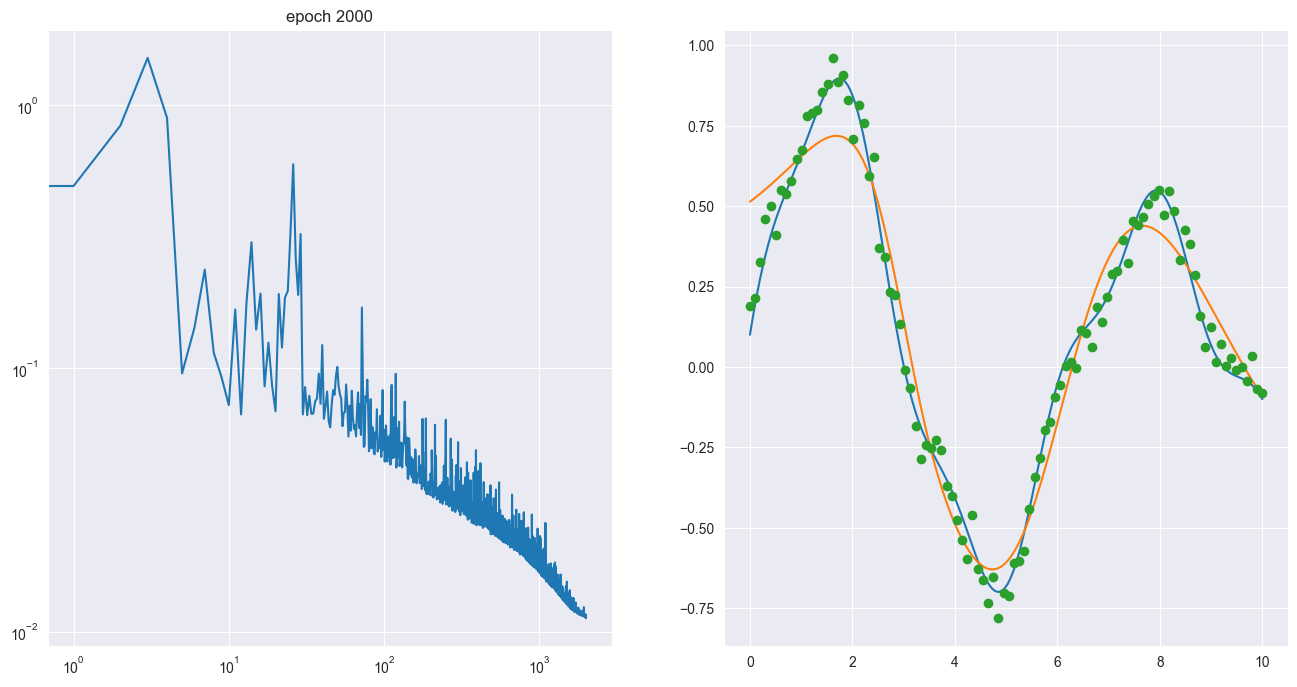

loss: 1.130e-02


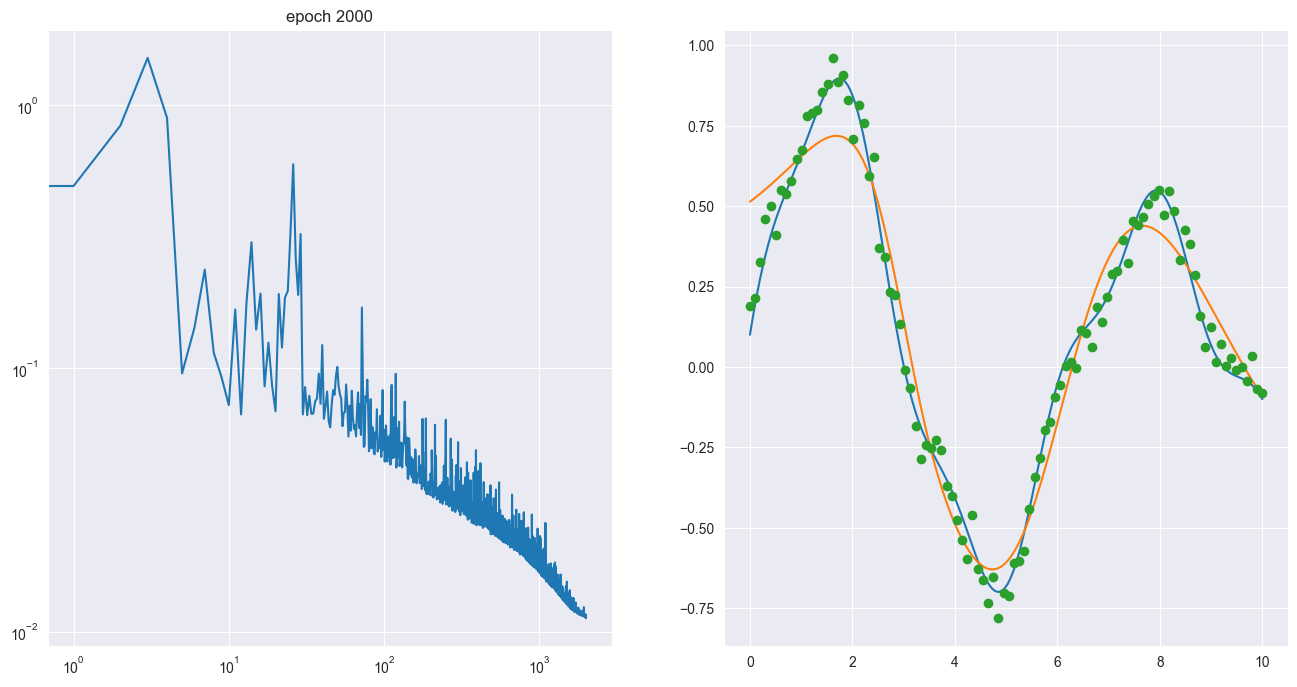

In [12]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 1e-1
batch_size = 10

lr_min = 1e-2
lr_max = 1e-1

dec_lr = lambda x, i: max(lr_min, lr_max * (1 - i / num_epochs)) # linear decay
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 200)

for epoch in range(num_epochs):
  idx = np.random.choice(np.arange(xx.shape[0]), batch_size, replace=True)
  grads = grad_jit(xx[idx], yy[idx], params)
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]
  history.append(loss_jit(xx, yy, params))
  learning_rate = dec_lr(learning_rate, epoch)
  cb(epoch)
#cb.draw()

print('loss: %1.3e' % history[-1])

## Stochastic Gradient Descent with momentum

Implement the SGD method with momentum:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{v}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}}\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{v}^{(k+1)} = \alpha \mathbf{v}^{(k)} -  \lambda_k \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} + \mathbf{v}^{(k+1)}
\end{split}
$$

Test different choices of $\alpha$.
Sommi la direzione di prima (pesata) e la direzione in cui vorresti andare

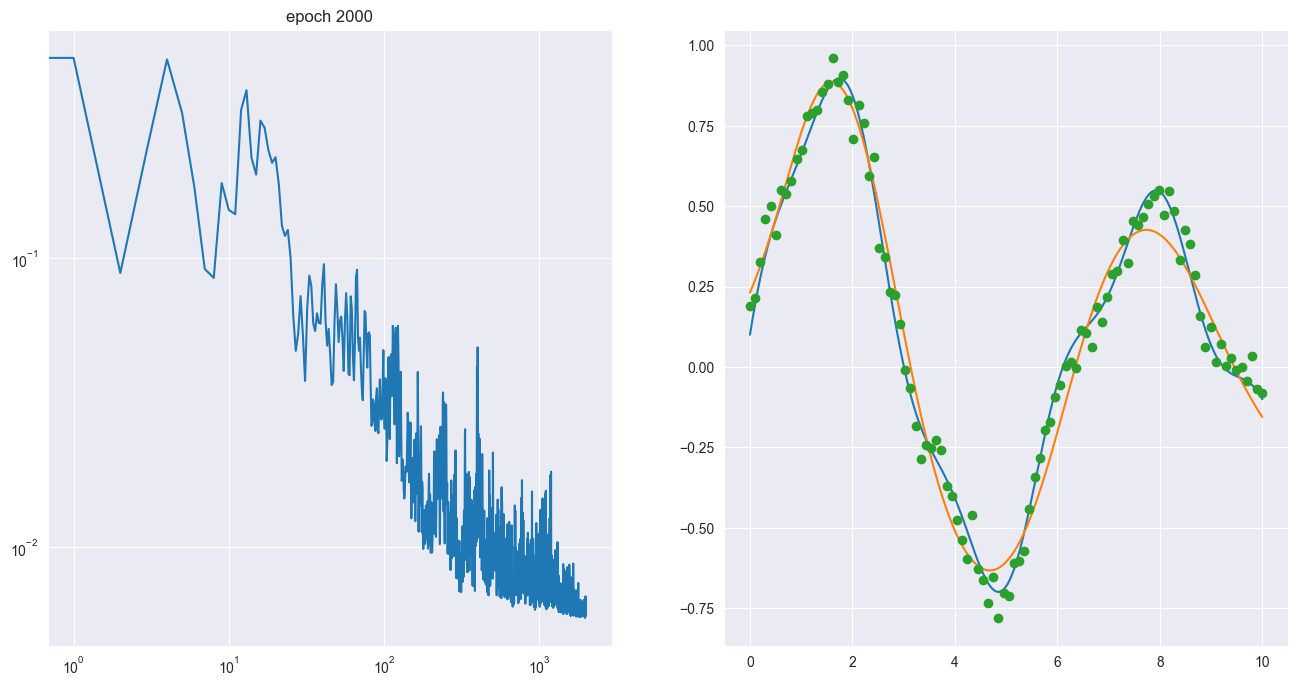

loss: 6.010e-03


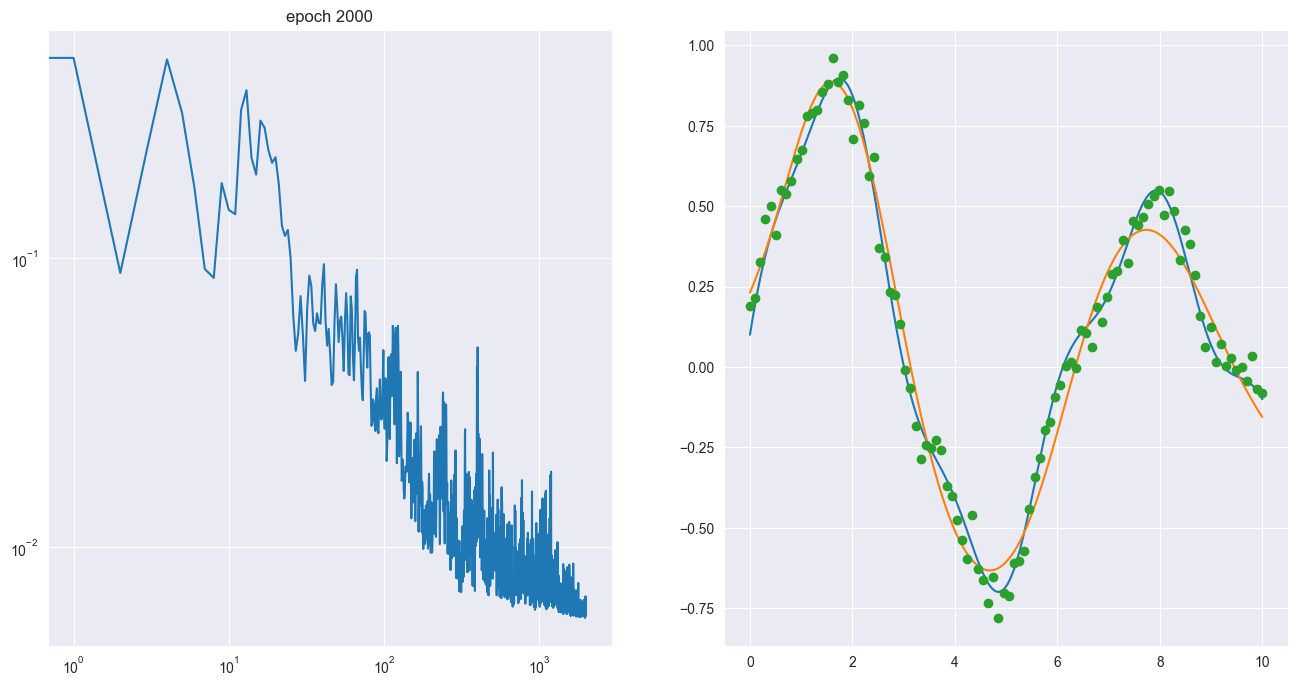

In [14]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 1e-1
batch_size = 10

lr_min = 1e-2
lr_max = 1e-1

dec_lr = lambda x, i: max(lr_min, lr_max * (1 - i / num_epochs)) # linear decay
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 200)

v = [0 for _ in range(len(params))]
alpha = 0.9

for epoch in range(num_epochs):
  idx = np.random.choice(np.arange(xx.shape[0]), batch_size, replace=True)
  grads = grad_jit(xx[idx], yy[idx], params)
  for i in range(len(params)):
    v[i] = alpha * v[i] - learning_rate * grads[i] # new grads are more significant than the others -- exponential weighting
    params[i] += v[i]
  history.append(loss_jit(xx, yy, params))
  learning_rate = dec_lr(learning_rate, epoch)
  cb(epoch)
#cb.draw()

print('loss: %1.3e' % history[-1])

## AdaGrad

Implement the AdaGrad algorithm:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{r}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{r}^{(k+1)} = \mathbf{r}^{(k)} + \mathbf{g}^{(k)} \odot \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - 
\frac{\lambda}{\delta + \sqrt{\mathbf{r}^{(k+1)}}} \odot \mathbf{g}^{(k)}
\end{split}
$$
where $\delta = 10^{-7}$ is a small constant.
Notice that the operations in the last line should be intepreted "componentwise".
Test different choices of the learning rate $\lambda$.

Tieni la somma cumulata dei gradienti al quadrato. quando è molto alta hai già imparato molto, smetti --> lambda va a zero

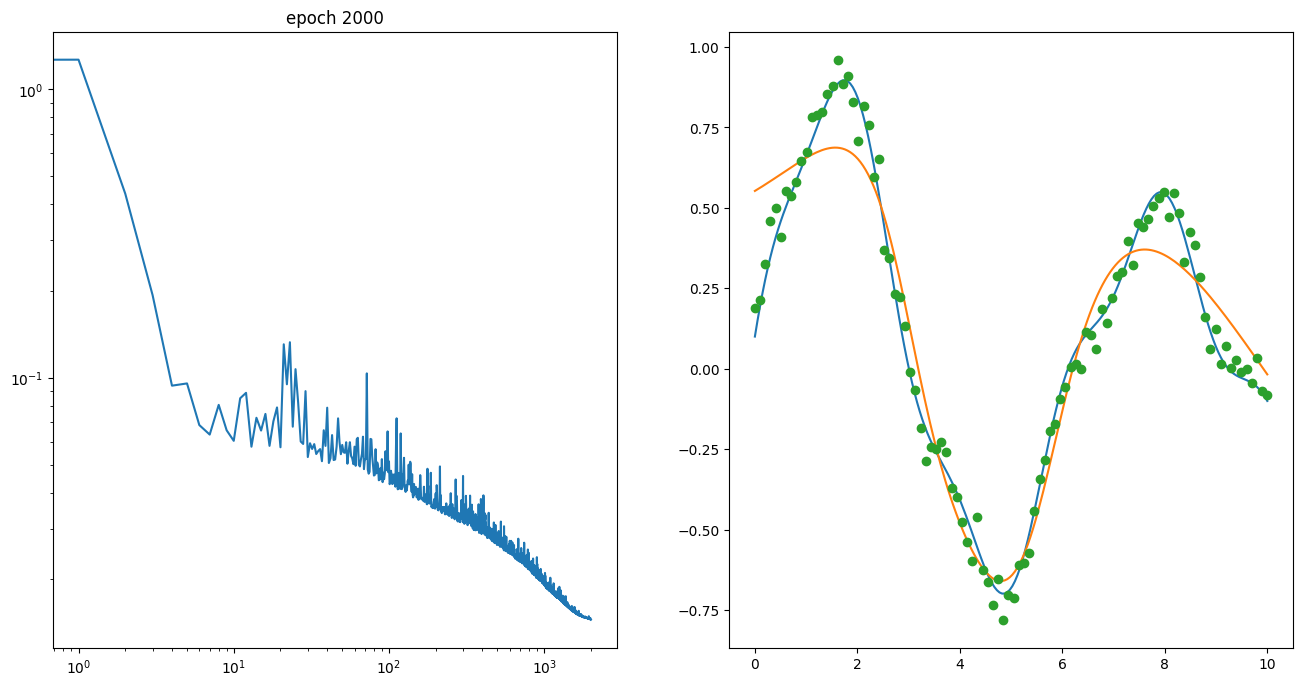

loss: 1.450e-02


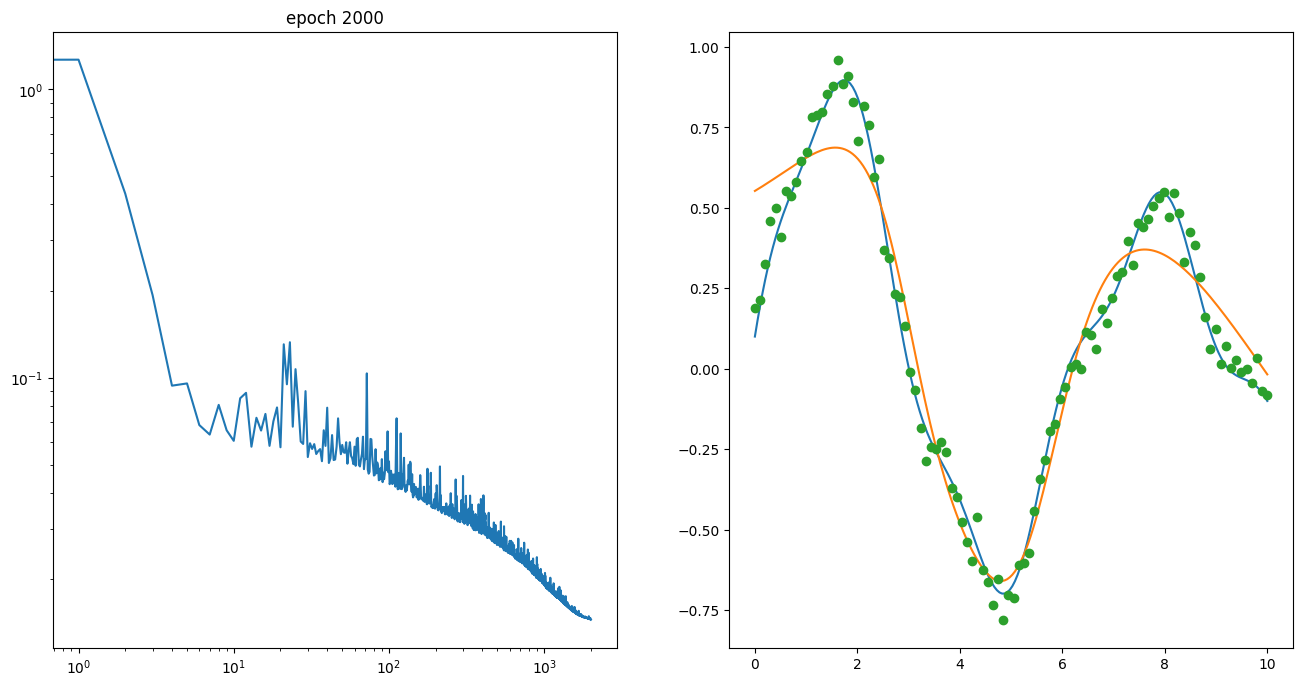

In [13]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 1e-1
batch_size = 10

lr_min = 1e-2
lr_max = 1e-1

dec_lr = lambda x, i: max(lr_min, lr_max * (1 - i / num_epochs)) # linear decay
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 200)

r = [0 for _ in range(len(params))]
delta = 1e-7

for epoch in range(num_epochs):
  idx = np.random.choice(np.arange(xx.shape[0]), batch_size, replace=True)
  grads = grad_jit(xx[idx], yy[idx], params)
  for i in range(len(params)):
    r[i] += grads[i] ** 2
    params[i] -= (learning_rate / (delta + np.sqrt(r[i]))) * grads[i]
  history.append(loss_jit(xx, yy, params))
  learning_rate = dec_lr(learning_rate, epoch)
  cb(epoch)
#cb.draw()
print('loss: %1.3e' % history[-1])

## RMSProp

Implement the RMSProp algorithm:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{r}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{r}^{(k+1)} = \rho \mathbf{r}^{(k)} + (1 - \rho)\mathbf{g}^{(k)} \odot \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - 
\frac{\lambda}{\delta + \sqrt{\mathbf{r}^{(k+1)}}} \odot \mathbf{g}^{(k)}
\end{split}
$$
where $\delta = 10^{-7}$ is a small constant.
Test different choices of the learning rate $\lambda$ and decay rate $\rho$.

Stessa cosa di AdaGrad ma evita di che il gradiente sparisca (o esploda). pesa i valori in percentuale

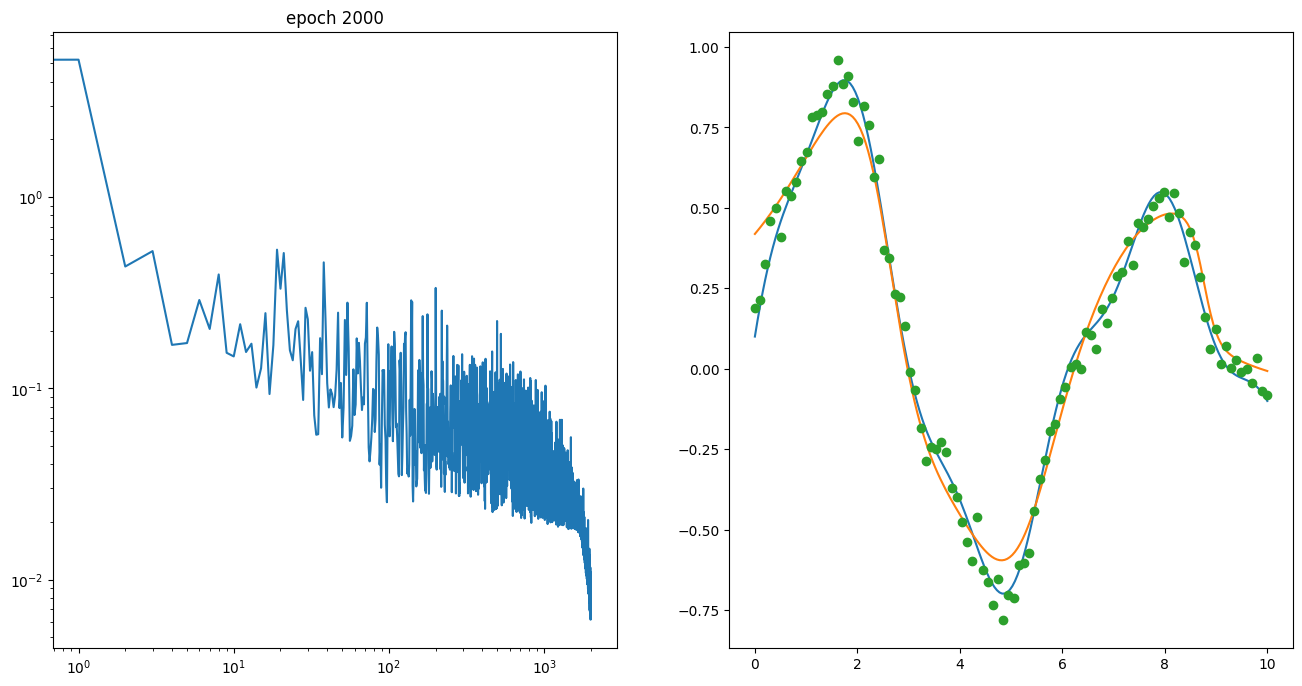

loss: 6.287e-03


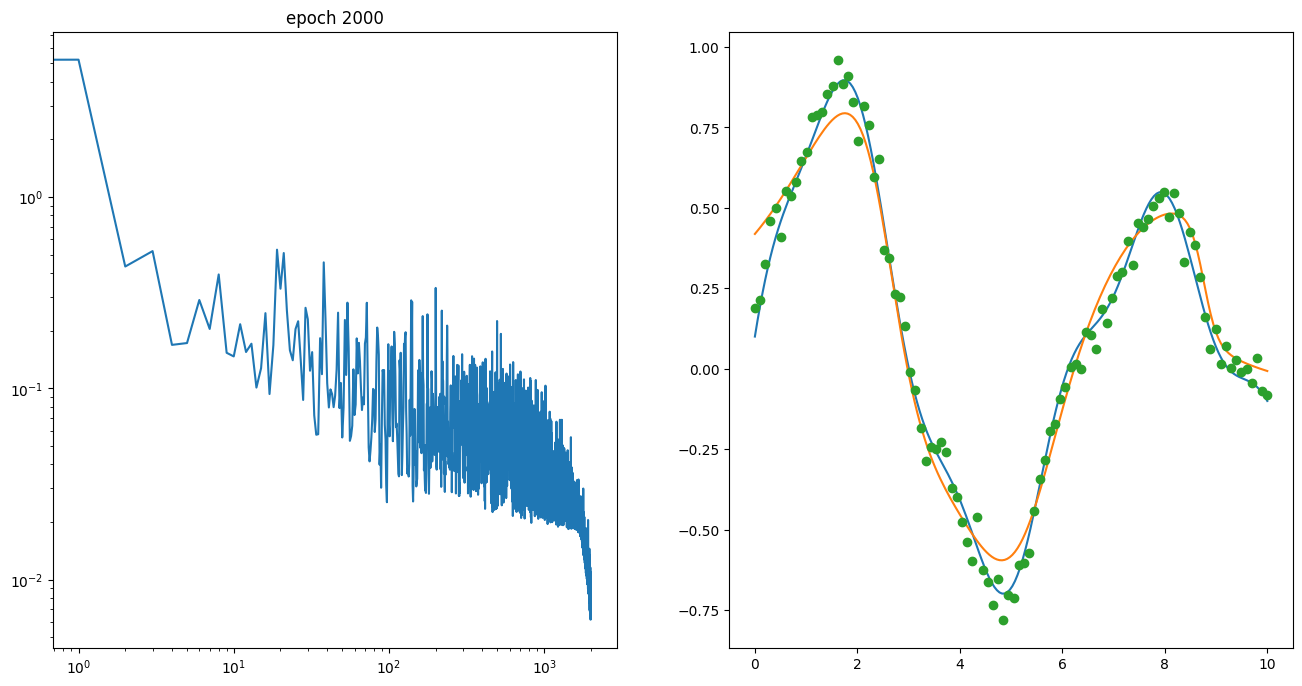

In [14]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 1e-1
batch_size = 10

lr_min = 1e-2
lr_max = 1e-1

dec_lr = lambda x, i: max(lr_min, lr_max * (1 - i / num_epochs)) # linear decay
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 200)

r = [0 for _ in range(len(params))]
delta = 1e-7
ro = 0.8

for epoch in range(num_epochs):
  idx = np.random.choice(np.arange(xx.shape[0]), batch_size, replace=True)
  grads = grad_jit(xx[idx], yy[idx], params)
  for i in range(len(params)):
    r[i] = ro * r[i] + (1 - ro) * grads[i] ** 2
    params[i] -= (learning_rate / (delta + np.sqrt(r[i]))) * grads[i]
  history.append(loss_jit(xx, yy, params))
  learning_rate = dec_lr(learning_rate, epoch)
  cb(epoch)
#cb.draw()

print('loss: %1.3e' % history[-1])

# ADAM --> Standard de Facto

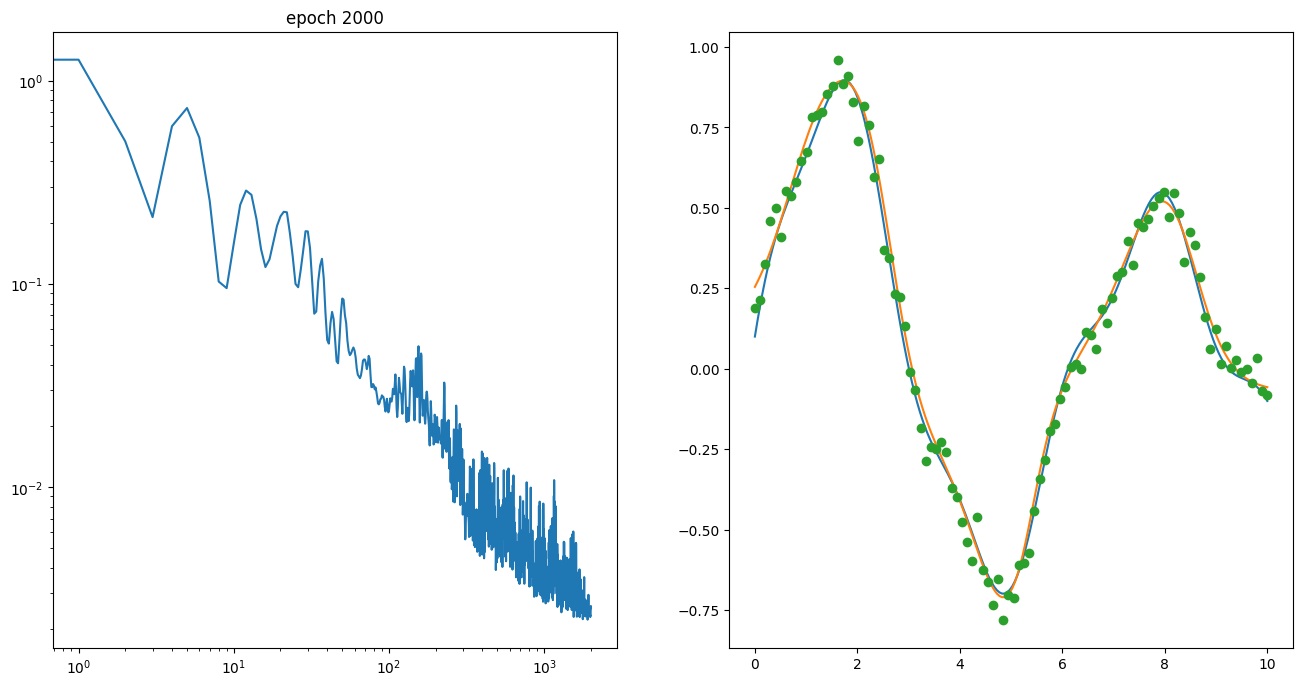

loss: 2.539e-03


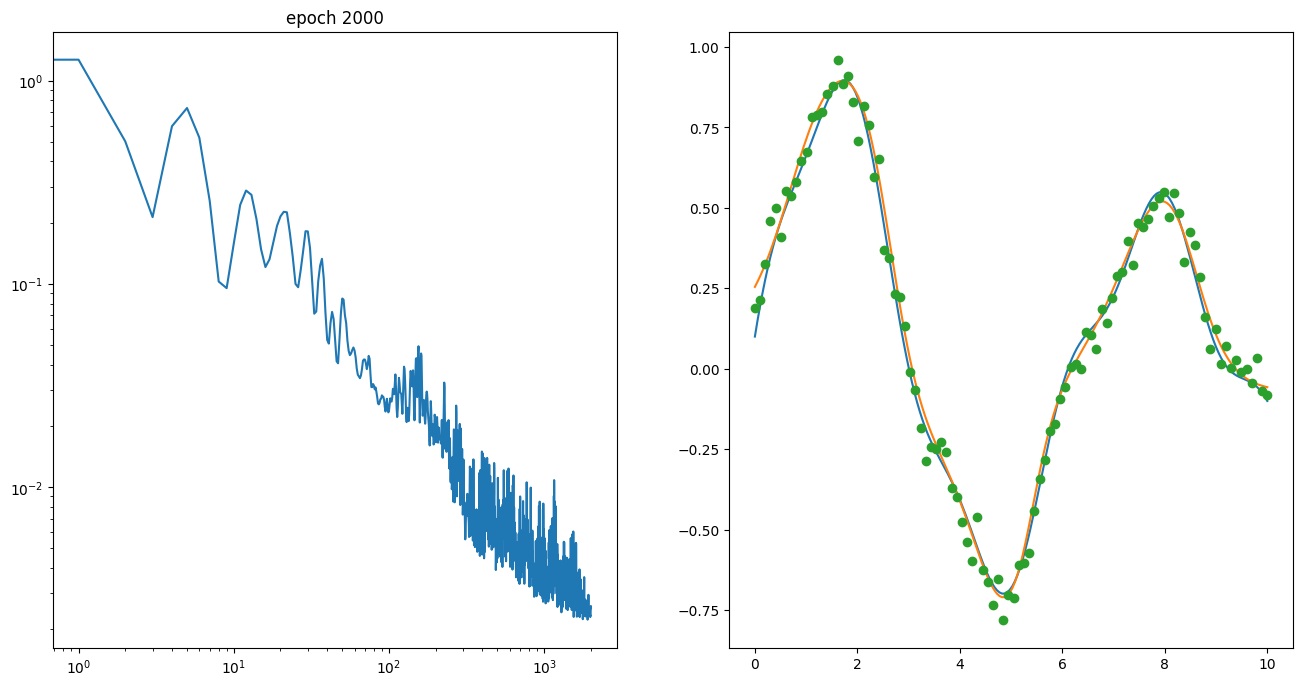

In [15]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 1e-1
batch_size = 10

lr_min = 1e-2
lr_max = 1e-1

dec_lr = lambda x, i: max(lr_min, lr_max * (1 - i / num_epochs)) # linear decay
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 200)

m = [0 for _ in range(len(params))]
v = [0 for _ in range(len(params))]
eps = 1e-7
beta_1, beta_2 = 0.9, 0.999

for epoch in range(num_epochs):
  idx = np.random.choice(np.arange(xx.shape[0]), batch_size, replace=True)
  grads = grad_jit(xx[idx], yy[idx], params)
  for i in range(len(params)):
    m[i] = beta_1 * m[i] + (1 - beta_1) * grads[i]
    v[i] = beta_2 * v[i] + (1 - beta_2) * np.square(grads[i])

    # unbiased version of the estimators
    m_hat = m[i] / (1 - np.power(beta_1, epoch + 1))
    v_hat = v[i] / (1 - np.power(beta_2, epoch + 1))

    params[i] -= learning_rate * m_hat / (np.sqrt(v_hat) + eps) # fastest convergence of all the algorithms

  history.append(loss_jit(xx, yy, params))
  learning_rate = dec_lr(learning_rate, epoch)
  cb(epoch)

print('loss: %1.3e' % history[-1])